In [52]:
# Importing the necessary libraries

import numpy as np
import requests
import gzip
import os
import hashlib
import matplotlib.pyplot as plt
import time

In [106]:
# Functions used for importing and engineering data, model creating, model training and model evaluation and training visualization

# Function for downloading the mnist dataset
def download_data(url):
    data = requests.get(url).content
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

# Function for splitting the training dataset into training and validation dataset
def data_splitting(X,Y,test_size=0.15):
    rand=np.arange(X.shape[0])
    np.random.shuffle(rand)
    train_no=rand[:int(X.shape[0]*(1-test_size))]
    validation_no=[i for i in range(X.shape[0]) if i not in train_no]
    X_train,X_validation=X[train_no,:,:],X[validation_no,:,:]
    Y_train,Y_validation=Y[train_no],Y[validation_no]
    return X_train,X_validation,Y_train,Y_validation

# Function that takes as input the dimensions of the matrix and returns the randomly initilised matrix
def weight_initialization(x_dim,y_dim):
    layers=np.random.uniform(-1.,1.,size=(x_dim,y_dim))/((x_dim*y_dim)**(0.5))
    return layers.astype(np.float32)


# Function for converting the scalar outputs into one-hot-endcoded outputs  
def one_hot_encoding(y,no_of_classes):
    temp=[]
    for j in range(len(y)):
        temp.append([0. for i in range(no_of_classes)])
    temp=np.array(temp)
    for i in range(len(y)):
        temp[i][y[i]]=1
    return temp

# Function for Forward and Backward propagation 
def forward_backward_pass(x,y,l1,no_of_classes=10):
    curr_scores = np.dot(x, l1)
    exp_scores = np.exp(curr_scores - np.max(curr_scores, axis=1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    encoded_y=one_hot_encoding(y,no_of_classes)
    loss = 0.5 * np.mean(np.linalg.norm((encoded_y.T - l1.T.dot(x.T)).T, ord=2, axis=1) ** 2)
    gradient_scores = probs - encoded_y
    update_l1=x.T.dot(gradient_scores)
    return update_l1,loss


# Function to generate random batches
def generate_random_batches(X_train,batch_size):
    batch=[]
    while(len(batch)!=batch_size):
        idx=np.random.randint(0,X_train.shape[0])
        if idx not in batch:
            batch.append(idx)
    return batch

# Function for training of the model
def model_train(l1,X_train,X_validation,Y_train,Y_validation,epochs,learning_rate,batch_size,no_of_classes):
    X_train=X_train.reshape(-1,28*28)
    X_validation=X_validation.reshape((-1,28*28))
    print("-----------------------------------------------------------------------------------------------")
    print("Training the model on the following parameters:-")
    print()
    print(f"X_train:-{X_train.shape},X_validation:-{X_validation.shape},Y_train:-{Y_train.shape},Y_validation:-{Y_validation.shape}")
    print(f"Epochs:-{epochs},Learning Rate:-{learning_rate},Batch Size:-{batch_size}")
    print()
    num_features = X_train.shape[1]
    
    training_accuracies=[]
    validation_accuracies=[]
    training_losses=[]

    for epoch in range(epochs+1):
        # Create a batch of input samples and corresponding labels
        curr_batch=generate_random_batches(X_train,batch_size)
        x_batch=X_train[curr_batch,:]
        y_batch=Y_train[curr_batch]
            
        # Forward and Backward pass
        update_l1,loss=forward_backward_pass(x_batch,y_batch,l1,no_of_classes=10)
        training_losses.append(loss)
        # Update weights
        l1=l1-(learning_rate*update_l1)

    # Calculate training accuracy for this epoch
        predicted_class = np.argmax(np.dot(X_train, l1), axis=1)
        training_accuracy = (predicted_class == Y_train).mean()
        training_accuracies.append(training_accuracy)
        if(epochs%20==0):
            val_predicted_class=np.argmax(np.dot(X_validation, l1), axis=1)
            validation_accuracy=(val_predicted_class==Y_validation).mean()
            validation_accuracies.append(validation_accuracy.item())
        if(epoch%100==0):
            print(f"Epoch number {epoch}: Train Accuracy: {training_accuracy:.2f} | Validation Accuracy:{validation_accuracy:.2f}")
    print()
    print("Training completed!")
    return l1,training_accuracies,validation_accuracies,training_losses


# Function for visualization of the model training and performace on the train data and validation data
def training_visualization(accuracies,val_accuracies,losses,batch_size):
    print()
    print(f"Visualization of the model training and performace for the batch size {batch_size}")
    # Train data
    plt.ylim(-0.1,1.1)
    plt.plot(accuracies)
    plt.title("Model's Performance on the Training Data")
    plt.xlabel("No of Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    plt.plot(losses)
    plt.title("Model's progress of the Training loss")
    plt.xlabel("No of Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Validation data
    plt.plot(val_accuracies)
    plt.title("Model's Performance on the Test Data")
    plt.xlabel("No of Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    return
    
# Function for testing/evaluating our trained model on the test(Unseen) data
def model_evaluation(l1,X_test,Y_test):
    test_predicted_class=np.argmax(np.dot(X_test.reshape(-1,28*28), l1), axis=1)
    test_accuracy=(test_predicted_class==Y_test).mean()
    print("The accuracy of our trained model on the Test Data is",test_accuracy*100,"%")
    print("-----------------------------------------------------------------------------------------------")
    print()
    return test_accuracy

# Function for fitting the model's parameters and running the Stochastic Gradient Descent and evaulating the trained model on the test data
def model_compile_fit(X_train,Y_train,X_validation,Y_validation,X_test,Y_test,batch_size,learning_rate,epochs,no_of_classes):
    # Initializing the neural model's layer's weights ramdomly

    l1=weight_initialization(28*28,10)

    # Stochastic Gradient Descent:- Instead of considering the entire training data, we take random batches of fixed size 

    l1,accuracies,val_accuracies,losses=model_train(l1,X_train,X_validation,Y_train,Y_validation,epochs,learning_rate,batch_size,no_of_classes)

    # Testing/Evaluating our trained model on the test(Unseen) data

    return model_evaluation(l1,X_test,Y_test),accuracies,val_accuracies,losses

# Function for finding the best matches for our hyper-parameters (Batch Size, Number of Epochs and Learning Rates)
def finding_the_best_match(batch_sizes,learning_rates,epochs_list,no_of_classes):
    best_match={i:() for i in batch_sizes}
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for epochs in epochs_list:
                test_accuarcy,accuracies,val_accuracies,losses=model_compile_fit(X_train,Y_train,X_validation,Y_validation,X_test,Y_test,batch_size,learning_rate,epochs,no_of_classes)
                if(best_match[batch_size]==tuple() or best_match[batch_size][0]<test_accuarcy):
                    best_match[batch_size]=tuple([test_accuarcy,tuple(accuracies),tuple(val_accuracies),tuple(losses)])
    return best_match

In [100]:
# Question 1 and Question 2

In [83]:
# Downloading the mnist dataset from the internet

X=download_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
X=X[0x10:].reshape((-1, 28, 28))
Y=download_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
Y=Y[8:]
X_test=download_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")
X_test=X_test[0x10:].reshape((-1, 28,28))
Y_test=download_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")
Y_test=Y_test[8:]

# Splitting the training dataset into training and validation dataset

X_train,X_validation,Y_train,Y_validation=data_splitting(X,Y)

In [ ]:
# Question 3

In [6]:
# List of Parameters for the batch_size, learning_rates, and number of epochs

batch_sizes=[1,10,100,1000]
learning_rates=[1e-5,1e-4,1e-3,1e-2]
epochs_list=[1000,5000,10000]

# Finding the best match of the hyperparameters to get the best results/accuracy on the test data for each batch size

no_of_classes=10
best_match=finding_the_best_match(batch_sizes,learning_rates,epochs_list,no_of_classes)

-----------------------------------------------------------------------------------------------
Training the model on the following parameters:-

X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-1000,Learning Rate:-1e-05,Batch Size:-1

Epoch number 0: Train Accuracy: 0.10 | Validation Accuracy:0.10
Epoch number 100: Train Accuracy: 0.43 | Validation Accuracy:0.42
Epoch number 200: Train Accuracy: 0.61 | Validation Accuracy:0.60
Epoch number 300: Train Accuracy: 0.65 | Validation Accuracy:0.64
Epoch number 400: Train Accuracy: 0.73 | Validation Accuracy:0.72
Epoch number 500: Train Accuracy: 0.70 | Validation Accuracy:0.70
Epoch number 600: Train Accuracy: 0.75 | Validation Accuracy:0.74
Epoch number 700: Train Accuracy: 0.71 | Validation Accuracy:0.70
Epoch number 800: Train Accuracy: 0.63 | Validation Accuracy:0.63
Epoch number 900: Train Accuracy: 0.75 | Validation Accuracy:0.75
Epoch number 1000: Train Accuracy: 0.76 | Validation Accura


----------------------------------------------------------------------------------------------

Visualization of the model training and performace for the batch size 1


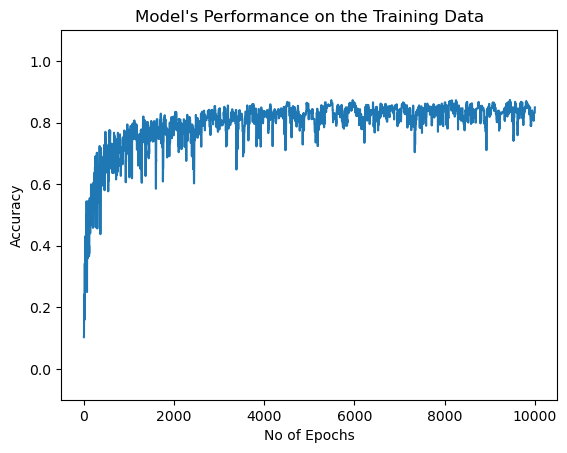

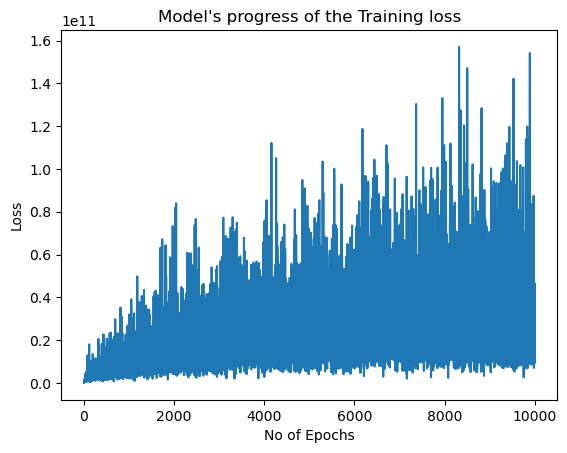

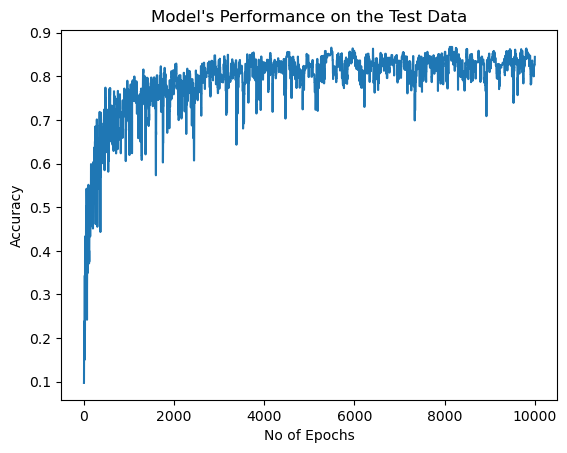

The test data accuracy for the trained model is 85.340 %
----------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------

Visualization of the model training and performace for the batch size 10


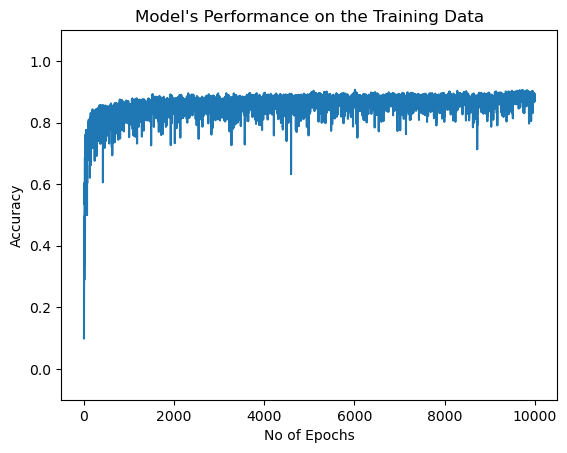

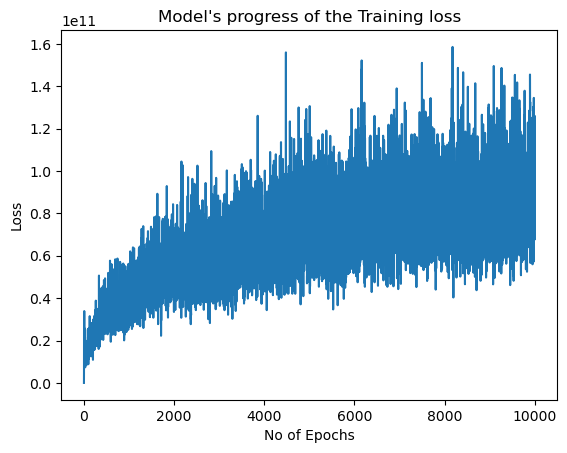

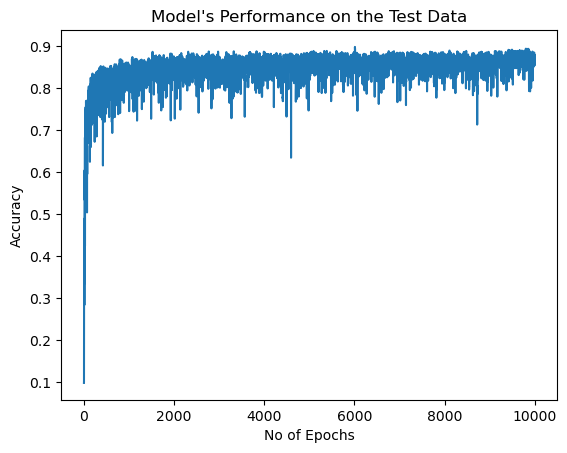

The test data accuracy for the trained model is 89.510 %
----------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------

Visualization of the model training and performace for the batch size 100


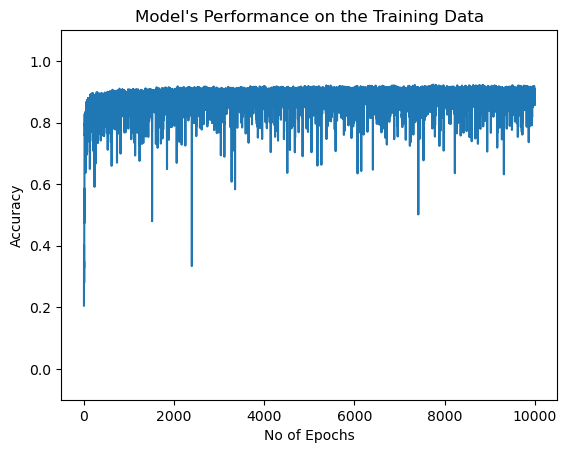

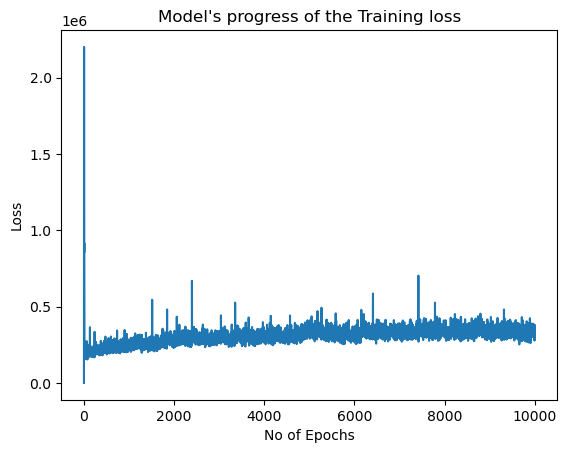

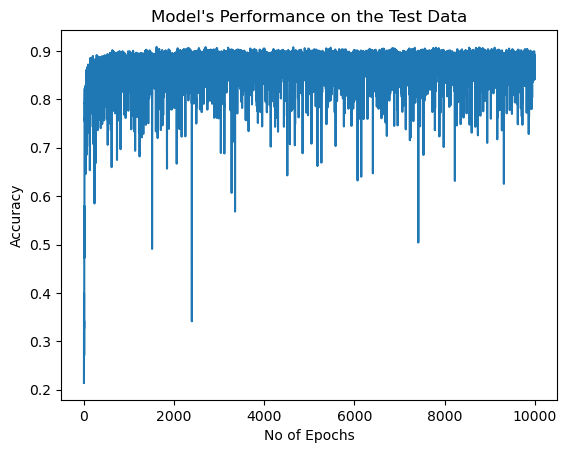

The test data accuracy for the trained model is 89.880 %
----------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------

Visualization of the model training and performace for the batch size 1000


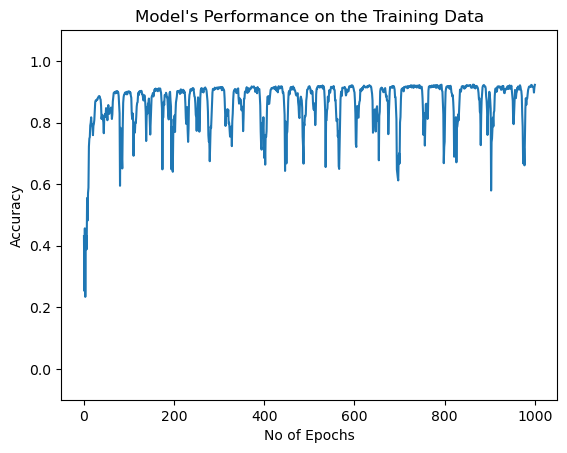

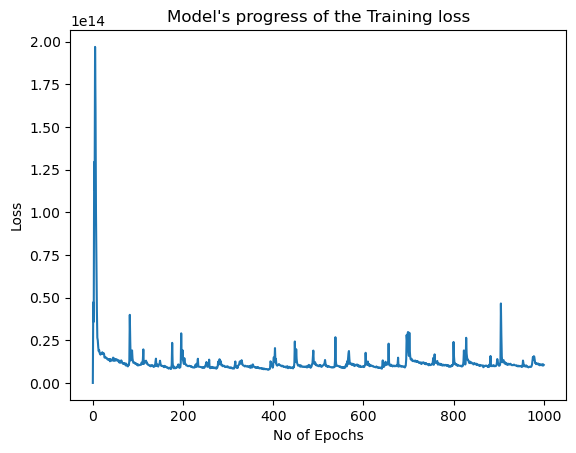

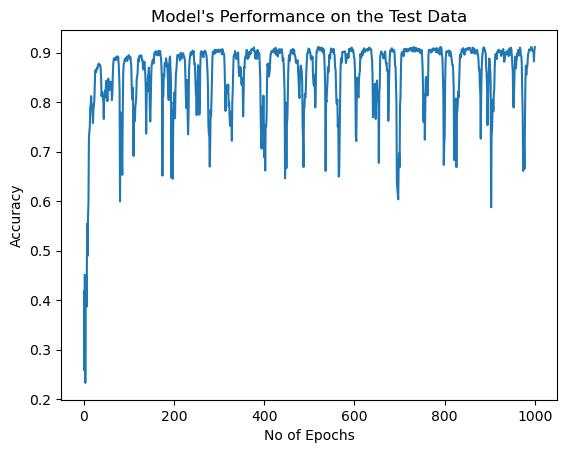

The test data accuracy for the trained model is 91.840 %
----------------------------------------------------------------------------------------------



In [107]:
for batch_size in batch_sizes:
    test_accuracy,accuracies,val_accuracies,losses=best_match[batch_size]
    print()
    print("----------------------------------------------------------------------------------------------")
    training_visualization(accuracies,val_accuracies,losses,batch_size)
    print(f"The test data accuracy for the trained model is {test_accuracy*100:.3f} %")
    print("----------------------------------------------------------------------------------------------")
    print()

In [ ]:
"""
Analysis

1. Best match for batch size 1:- X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-10000,Learning Rate:-0.01,Batch Size:-1,Test accuracy:-0.8534

2. Best match for batch size 10:- X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-10000,Learning Rate:-0.01,Batch Size:-10,,Test accuracy:-0.8951

3. Best match for batch size 100:- X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-10000,Learning Rate:-1e-05,Batch Size:-100,,Test accuracy:-0.8988

4. Best match for batch size 1000:- X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-1000,Learning Rate:-0.01,Batch Size:-1000,,Test accuracy:-0.9184

Hence, the result of the analysis is that with the increase in the size of the batch, the number of epochs tends to decrease 
and the learning rate tends to increase for a better accuracy. 
"""

In [ ]:
# Question 4

In [105]:
# Training our model on different sizes of the dataset, to analyse the impact of the size of the dataset

# Downloading the mnist dataset from the internet

path=r"C:\Users\DEEP\Downloads\mnist_project"

X=download_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
X=X[0x10:].reshape((-1, 28, 28))
Y=download_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
Y=Y[8:]
X_test=download_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")
X_test=X_test[0x10:].reshape((-1, 28,28))
Y_test=download_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")
Y_test=Y_test[8:]

dataset_sizes=[100,500,1000,10000]
dataset_match={}

for i in range(len(dataset_sizes)):
    X1=X[:dataset_sizes[i]]
    Y1=Y[:dataset_sizes[i]]
    X_train,X_validation,Y_train,Y_validation=data_splitting(X1,Y1,test_size=0)

    batch_size=100
    learning_rate=0.001
    epochs=10000
    no_of_classes=10

    test_accuarcy,accuracies,val_accuracies,losses=model_compile_fit(X_train,Y_train,X_validation,Y_validation,X_test,Y_test,batch_size,learning_rate,epochs,no_of_classes)
    dataset_match[dataset_sizes[i]]=tuple([test_accuarcy,tuple(accuracies),tuple(val_accuracies),tuple(losses)])

-----------------------------------------------------------------------------------------------
Training the model on the following parameters:-

X_train:-(100, 784),X_validation:-(0, 784),Y_train:-(100,),Y_validation:-(0,)
Epochs:-10000,Learning Rate:-0.001,Batch Size:-100

Epoch number 0: Train Accuracy: 0.27 | Validation Accuracy:nan


C:\Users\DEEP\AppData\Local\Temp\ipykernel_8740\3607057148.py:89: RuntimeWarning: Mean of empty slice.
  validation_accuracy=(val_predicted_class==Y_validation).mean()
C:\Users\DEEP\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch number 100: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 200: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 300: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 400: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 500: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 600: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 700: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 800: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 900: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1000: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1100: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1200: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1300: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1400: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1500: Train Accuracy: 1.00 | Validation Accuracy:nan
Epoch number 1600: 

In [ ]:
"""
Analysis

Test accuracy for dataset size 100:-60.75
Test accuracy for dataset size 500:-80.63
Test accuracy for dataset size 1000:-83.77
Test accuracy for dataset size 10000:-87.94

There is a clear trend that with the increase in the dataset size, the accuracy of the model on the test data increases
"""

In [ ]:
# Question 5

In [78]:
# Implementation of the MNIST problem using the Tensorflow Library

# Importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import hashlib
import gzip
import tensorflow as tf
import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.losses import sparse_categorical_crossentropy,categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Functions used for preprocessing of the input and output data.
def input_preprocessing(X):
    X=X.reshape(-1,28*28)
    X=X/255.
    return X
def output_preprocessing(Y):
    Y=Y.reshape(-1,1)
    encoder=OneHotEncoder(sparse=False)
    Y_encoded=encoder.fit_transform(Y)
    return Y_encoded

# Function for building/constructing the model
def model_construction():
    model=Sequential()
    model.add(Dense(10,input_shape=(784,),activation="softmax"))
    return model

# Downloading the data from the internet
X = download_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = download_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = download_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28,28))
Y_test = download_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

# Pre-processing the data
X,Y_encoded=input_preprocessing(X),output_preprocessing(Y)

# Splitting the data for the purpose of training and validation during the model training
X_train,X_validation,Y_train,Y_validation=train_test_split(X,Y_encoded,test_size=0.15,shuffle=True,random_state=42)

# Compiling and training the model on the train data and validating it using the validation data
model=model_construction()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"],)
history=model.fit(X_train,Y_train,validation_data=(X_validation,Y_validation),epochs=100,batch_size=100)
test_accuracy=model.evaluate(input_preprocessing(X_test),output_preprocessing(Y_test))[1]*100
print(f"The accuracy of our model on the test(unseen) data is {test_accuracy:.3f}")

Epoch 1/100
510/510 [==============================] - 1s 2ms/step - loss: 1.2243 - accuracy: 0.7126 - val_loss: 0.8101 - val_accuracy: 0.8241
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.6896 - accuracy: 0.8453 - val_loss: 0.6168 - val_accuracy: 0.8503
Epoch 3/100
510/510 [==============================] - 1s 1ms/step - loss: 0.5684 - accuracy: 0.8632 - val_loss: 0.5374 - val_accuracy: 0.8658
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.5102 - accuracy: 0.8720 - val_loss: 0.4932 - val_accuracy: 0.8731
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.8788 - val_loss: 0.4639 - val_accuracy: 0.8782
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.4506 - accuracy: 0.8830 - val_loss: 0.4428 - val_accuracy: 0.8811
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.4325 - accuracy: 0.8870 - val_loss: 0.4265 - val_accuracy: 0.8843

-----------------------------------------------------------------------------------------------
Training the model on the following parameters:-

X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-100,Learning Rate:-0.01,Batch Size:-100

Epoch number 0: Train Accuracy: 0.32 | Validation Accuracy:0.31
Epoch number 100: Train Accuracy: 0.88 | Validation Accuracy:0.87

Training completed!
The accuracy of our trained model on the Test Data is 87.96000000000001 %
-----------------------------------------------------------------------------------------------

Training loss and accuracy graphs for the tensorflow model


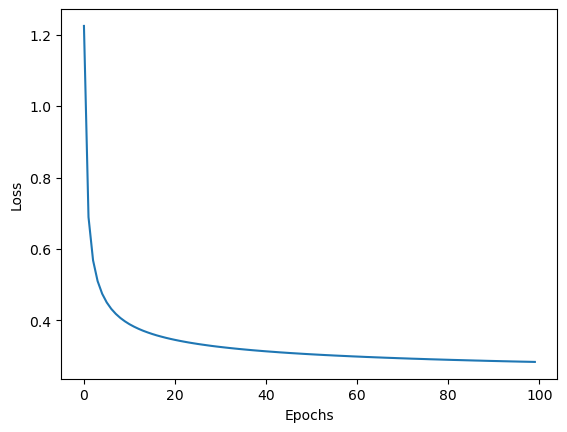

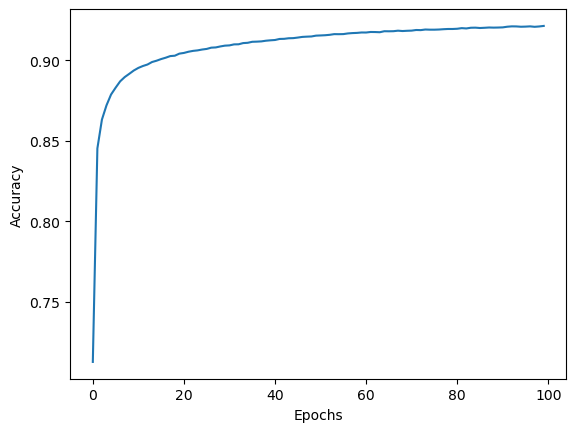


Training loss and accuracy graphs for the custom model

Visualization of the model training and performace for the batch size 100


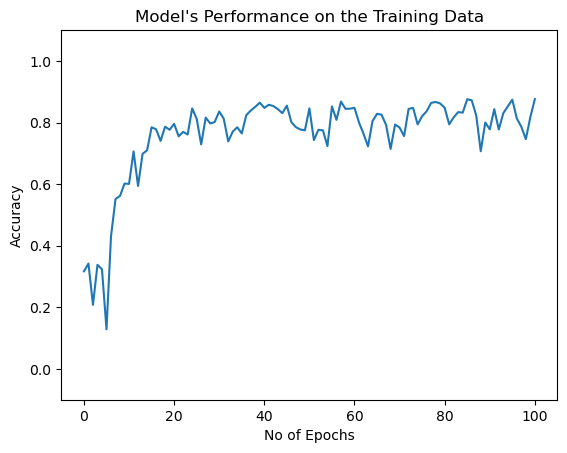

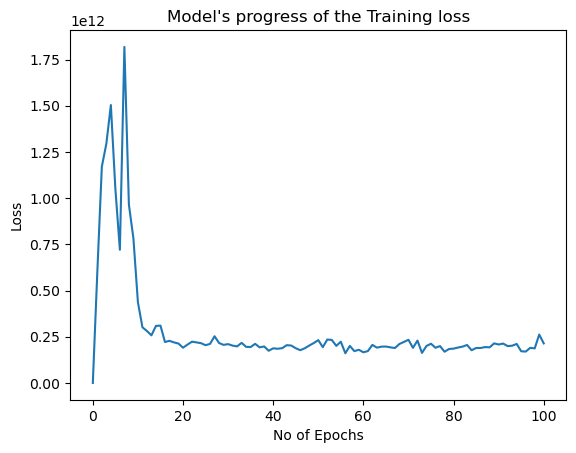

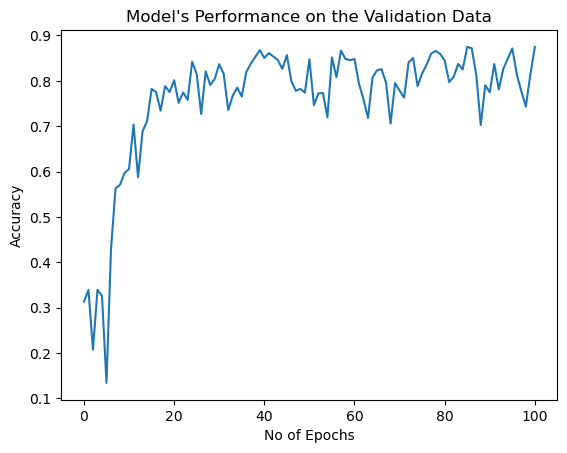

In [99]:
loss_train = history.history['loss']
accuracy_train=history.history['accuracy']

# Custom model training on the same parameters for comparision
test_accuarcy,accuracies,val_accuracies,losses=model_compile_fit(X_train,Y_train,X_validation,Y_validation,X_test,Y_test,batch_size=100,learning_rate=0.01,epochs=100,no_of_classes=10)


print("Training loss and accuracy graphs for the tensorflow model")
plt.plot(loss_train, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(accuracy_train, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print()

print("Training loss and accuracy graphs for the custom model")
training_visualization(accuracies,val_accuracies,losses,batch_size=100)
print()

In [102]:
"""
Analysis

For the batch size of 100, number of epochs 100 and learning rate of 0.01, the model that we trained using the tensorflow,
got a test accuracy of 92.10 percent whereas, the model that we built and trained without using tensorflow got a test
accuracy of 86.15 percent. The 6% accuracy difference between the custom model and the TensorFlow model can be attributed 
to TensorFlow's optimized architecture, tuned hyperparameters, and data preprocessing.
"""

"\nAnalysis\n\nFor the batch size of 100, number of epochs 100 and learning rate of 0.01, the model that we trained using the tensorflow,\ngot a test accuracy of 92.10 percent whereas, the model that we built and trained without using tensorflow got a test\naccuracy of 86.15 percent. The 6% accuracy difference between the custom model and the TensorFlow model can be attributed \nto TensorFlow's optimized architecture, tuned hyperparameters, and data preprocessing.\n"

In [101]:
# Time analysis for the question 2

In [55]:
# Training the model on different batch sizes and their respective best parameters for analysis of the model trainig time
no_of_classes=10
best_parameters=[[1,0.01,10000],[10,0.01,10000],[100,1e-05,10000],[1000,0.01,1000]]
time_list=[]
for batch_size,learning_rate,epochs in best_parameters:
    start_time=time.time()
    test_accuracy,accuracies,val_accuracies,losses=model_compile_fit(X_train,Y_train,X_validation,Y_validation,X_test,Y_test,batch_size,learning_rate,epochs,no_of_classes)
    end_time=time.time()
    time_taken=end_time-start_time
    print(f"The taken for the training of then model with the best parameters for the batch size {batch_size} is {time_taken} seconds")
    time_list.append(time_taken)

-----------------------------------------------------------------------------------------------
Training the model on the following parameters:-

X_train:-(51000, 784),X_validation:-(9000, 784),Y_train:-(51000,),Y_validation:-(9000,)
Epochs:-10000,Learning Rate:-0.01,Batch Size:-1

Epoch number 0: Train Accuracy: 0.10 | Validation Accuracy:0.10
Epoch number 100: Train Accuracy: 0.48 | Validation Accuracy:0.47
Epoch number 200: Train Accuracy: 0.58 | Validation Accuracy:0.57
Epoch number 300: Train Accuracy: 0.65 | Validation Accuracy:0.65
Epoch number 400: Train Accuracy: 0.64 | Validation Accuracy:0.64
Epoch number 500: Train Accuracy: 0.67 | Validation Accuracy:0.66
Epoch number 600: Train Accuracy: 0.69 | Validation Accuracy:0.69
Epoch number 700: Train Accuracy: 0.75 | Validation Accuracy:0.75
Epoch number 800: Train Accuracy: 0.79 | Validation Accuracy:0.78
Epoch number 900: Train Accuracy: 0.75 | Validation Accuracy:0.75
Epoch number 1000: Train Accuracy: 0.75 | Validation Accura

In [ ]:
"""
Analysis

While training with the best parameters (learning rate:0.01 and epochs:10000) for the batch size 1, it took 2003.044 seconds
for the training to complete.
While training with the best parameters (learning rate:0.01 and epochs:10000) for the batch size 10, it took 2052.87 seconds
for the training to complete.
While training with the best parameters (learning rate:0.00001 and epochs:10000) for the batch size 100, it took 2052.20 seconds
for the training to complete.
While training with the best parameters (learning rate:0.01 and epochs:1000) for the batch size 1000, it took 217.9 seconds
for the training to complete.
From the above it can be said that the training time is directly proportional to the number of epochs and inversely proportional
to the batch size and magnitude of the learning rate.
"""